### Import modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

In [6]:
from function import (
    plot_sounding,
    get_sounding_df
)

In [227]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )

### Load data from .csv

In [8]:
#please download data from "release" on the repository and rename the file_path below

file_path = "../../flight_line_101102_101201.csv"
file_path_all_data = "../../AusAEM_WA_Block_E_EM.csv"

df = pd.read_csv(file_path, 
                 delimiter=",") 

df_all = pd.read_csv(file_path_all_data, 
                 delimiter=",") 

# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_2763/1952385971.py:9: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(file_path_all_data,


In [85]:
# input flight line number and sounding ID
# 101102 or 101201
flightline = 101102 # or 101201

# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding = 7300 #7300

station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, sounding, df)

### Survey (Sounding-Independent)

1. Gate centre times

In [123]:
# load the gate opening time for LM and HM respectively
LM_excel = "../../LM_times.csv"
HM_excel = "../../HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [126]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

2. Waveform

In [117]:
LM_waveform_excel = "../../LM_waveform.csv"
HM_waveform_excel = "../../HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [119]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

3. Transmitter and Receiver Location

In [101]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
                     [ -6.15,  -8.59,   0.  ],
                     [  5.74,  -8.59,   0.  ],
                     [ 11.13,  -3.19,   0.  ],
                     [ 11.13,   3.19,   0.  ],
                     [  5.74,   8.59,   0.  ],
                     [ -6.15,   8.59,   0.  ],
                     [-12.64,   2.13,   0.  ],
                     [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

tx_area=342.0 # from data processing report

### Mesh Setup

In [138]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [140]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 63, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        434.09      1.00     21.62    1.05

### Survey (Sounding-dependent) 

In [315]:
# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding_list = [7400,7300,7200,7100,7000]
# Initialize an empty list to store the data
data_list = []

In [317]:
for i in sounding_list:
    df.iloc[i]

    # Extract sounding data
    station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, i, df)
    
    # add UTM coordinates to transmitter shape and the receiver offset
    tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]
    rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]

    # Define source for survey input
    # Low moment:
    rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, LM_times, orientation='z')
    lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)
    src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

    # high moment
    rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, HM_times, orientation='z')
    hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)
    src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

    # Define survey
    srv = tdem.Survey([src_lm, src_hm])

    # Observed data (normalised) & relative errors 
    dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
    rel_err = np.r_[station_lm_std, station_hm_std]
    data_container = data.Data(srv, dobs=dobs, relative_error=rel_err) # method 1 to obtain data_object

    # Halfspace Inversion
    m_0 = np.log(1E-2)  # sigma = 1E-2 S/m
    sim_inv_halfspace = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)
    phi_d_halfspace = L2DataMisfit(data=data_container, simulation=sim_inv_halfspace)
    minimizer = optimization.InexactGaussNewton(maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3)
    empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
    inv_prob_halfspace = inverse_problem.BaseInvProblem(phi_d_halfspace, reg=empty_reg, opt=minimizer, beta=0.0)
    inv_halfspace = inversion.BaseInversion(inv_prob_halfspace, [])
    recovered_model = inv_halfspace.run(m_0)
    
    # Inversion Setup
    sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])
    phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)
    reg = regularization.WeightedLeastSquares(mesh)
    m_0_reg = np.full(mesh.n_cells, recovered_model[0])
    minimizer_reg = optimization.InexactGaussNewton(maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3)
    inv_prob_3 = inverse_problem.BaseInvProblem(phi_d_reg, reg=reg, opt=minimizer_reg) #, beta=5 # change beta !)
    beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
    save_dict = directives.SaveOutputDictEveryIteration()
    inv3 = inversion.BaseInversion(inv_prob_3, [save_dict, beta_schedule])
    recovered_model_3 = inv3.run(m_0_reg)

    # Collect data for the current sounding
    data_list.append({
        'Easting': station["Easting"].iloc[0],
        'Thicknesses': sim_reg.thicknesses,
        'Sigma': sim_reg.sigma
    })

    


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  4.49e+07  0.00e+00  4.49e+07    1.56e+07      0              
   1  0.00e+00  7.03e+06  3.01e+00  7.03e+06    7.69e+06      1              
   2  0.00e+00  6.63e+06  3.35e+00  6.63e+06    3.09e+05      0   Skip BFGS  
   3  0.00e+00  6.62e+06  3.36e+00  6.62e+06    2.04e+04      0   Skip BFGS  
   4  0.00e+00  6.62e+06  3.37e+00  6.62e+06    1.36e+03      0   Skip BFGS  
   5  0

(0.001, 100000.0)

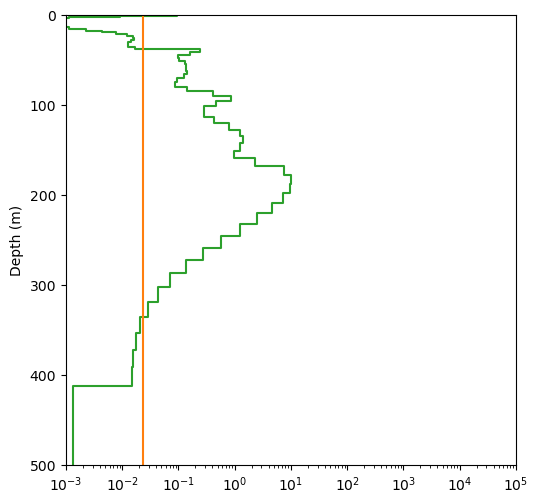

In [319]:
data_pre_3 = sim_reg.make_synthetic_data(recovered_model_3)
#ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax = plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma, color='C2')
ax.axvline(sim_inv_halfspace.sigma, color='C1')
ax.set_ylim([500, 0])
ax.set_xlim([1E-3, 1E5])

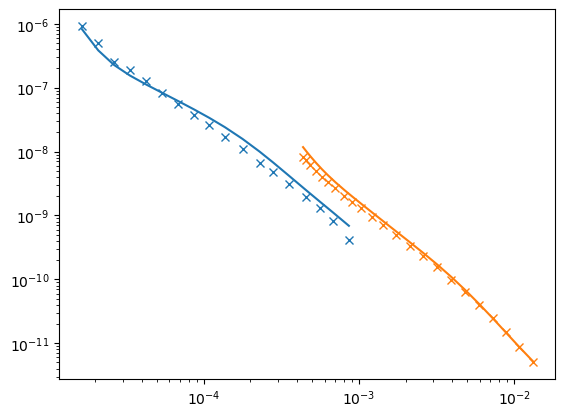

In [321]:
plot_data(data_pre_3)

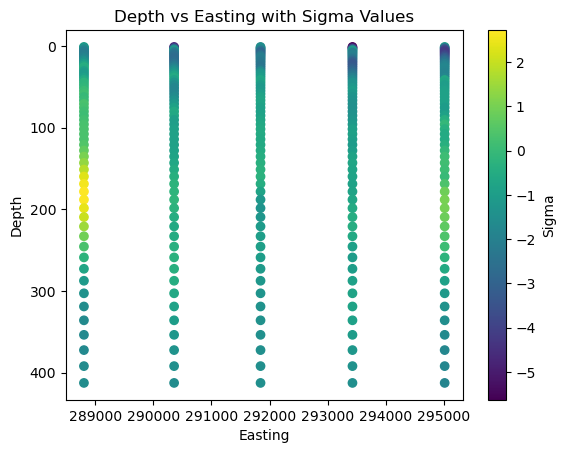

In [327]:
# Initialize lists to store cumulative thicknesses and sigma values
easting_list = []
depth_list = []
sigma_list = []

# Process each entry in the data
for entry in data_list:
    easting = entry['Easting']
    thicknesses = entry['Thicknesses']
    sigma = entry['Sigma']
    
    # Calculate cumulative thicknesses (depths)
    cumulative_thicknesses = np.cumsum(thicknesses)
    
    # Ensure the lengths match
    min_length = min(len(cumulative_thicknesses), len(sigma))
    cumulative_thicknesses = cumulative_thicknesses[:min_length]
    sigma = sigma[:min_length]
    
    # Append values to lists
    easting_list.extend([easting] * len(cumulative_thicknesses))
    depth_list.extend(cumulative_thicknesses)
    sigma_list.extend(sigma)

# Create a scatter plot
plt.scatter(easting_list, depth_list, c=np.log10(sigma_list), cmap='viridis')
plt.colorbar(label='Sigma')
plt.xlabel('Easting')
plt.ylabel('Depth')
plt.title('Depth vs Easting with Sigma Values')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()

In [325]:
data_list

[{'Easting': 288803.0,
  'Thicknesses': array([ 1.        ,  1.05      ,  1.1025    ,  1.157625  ,  1.21550625,
          1.27628156,  1.34009564,  1.40710042,  1.47745544,  1.55132822,
          1.62889463,  1.71033936,  1.79585633,  1.88564914,  1.9799316 ,
          2.07892818,  2.18287459,  2.29201832,  2.40661923,  2.5269502 ,
          2.65329771,  2.78596259,  2.92526072,  3.07152376,  3.22509994,
          3.38635494,  3.55567269,  3.73345632,  3.92012914,  4.1161356 ,
          4.32194238,  4.53803949,  4.76494147,  5.00318854,  5.25334797,
          5.51601537,  5.79181614,  6.08140694,  6.38547729,  6.70475115,
          7.03998871,  7.39198815,  7.76158756,  8.14966693,  8.55715028,
          8.98500779,  9.43425818,  9.90597109, 10.40126965, 10.92133313,
         11.46739979, 12.04076978, 12.64280826, 13.27494868, 13.93869611,
         14.63563092, 15.36741246, 16.13578309, 16.94257224, 17.78970085,
         18.67918589, 19.61314519, 20.59380245]),
  'Sigma': array([8.7363